In [17]:
import torch
import torch.nn as nn
import gym

from seagul.nn import Categorical_MLP, MLP, DummyNet, fit_model
from seagul.rl.ppo_switching import ppo_switch
from tqdm import trange
from numpy import pi
import numpy as np

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.double)

policy = MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)
value_fn = MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)
gate_fn = Categorical_MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)

In [13]:
# Generate data for the supervised learning task
env = gym.make('su_cartpole-v0')
num_points = int(2e4)

X = torch.zeros(num_points, env.observation_space.shape[0])  
Y = torch.zeros(num_points,1)

for i in trange(num_points):
        
        point = env.observation_space.sample()
        X[i] = torch.as_tensor(point)
        
        if (point[0] > 145 * pi / 180) and (point[0] < 215 * pi / 180):
            Y[i] = 1
        else:
            Y[i] = 0
            

100%|██████████| 20000/20000 [00:01<00:00, 15692.41it/s]


100%|██████████| 50/50 [00:33<00:00,  1.46it/s]


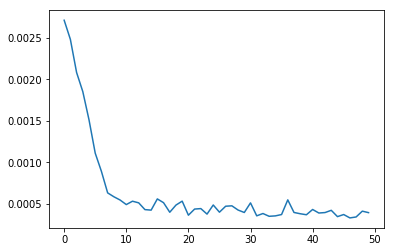

In [14]:
# fit our gating network to the data we generated above

hist = fit_model(gate_fn,X,Y,50)
plt.plot(hist)

In [5]:
# evauluate how well our classifier is doing now

env = gym.make('su_cartpole-v0')
num_points = int(2e4)

pred_Y = torch.zeros(num_points,1)
pred_X = np.zeros((num_points,1))
up_wrong = 0; up_right = 0; down_wrong = 0; down_right = 0;
for i in trange(num_points):
        
        point = env.observation_space.sample()
        y = gate_fn(torch.as_tensor(point,dtype=torch.float64))
        
        if (point[0] > 145 * pi / 180) and (point[0] < 215 * pi / 180):
            if y < .5:
                #print("wrong!" , c)
                up_wrong +=1
            else:
                up_right +=1
        else:
            if y > .5:
                #print("wrong again!" , c)
                down_wrong +=1
            else:
                down_right +=1
       
print("balancing controller misclassified: " , up_wrong)
print("balancing controller corectly classified: " , up_right)
print("balancing controller accuracy: " , up_right/(up_right+up_wrong))

     
print("swingup controller misclassified: " , down_wrong)
print("swingup controller corectly classified: " , down_right)
print("balancing controller accuracy: " , down_right/(down_right+down_wrong))

100%|██████████| 20000/20000 [00:04<00:00, 4690.68it/s]

0 1995 663 17342


100%|██████████| 500/500 [16:42<00:00,  2.05s/it]

[776.0207533172786, 1014.9143728454433, 778.2105336156033, 768.2814402619179, 694.1859456002385, 583.0643333332679, 914.9364077320678, 477.454227964168, 771.5222102300056, 763.6813171951271, 777.3182038986705, 769.4568761155887, 964.9712675491425, 784.093584460496, 762.4102318276452, 585.6293280876379, 904.3145508490144, 754.419904611313, 778.7369768473862, 624.4819802704252, 701.891669580329, 740.9132322192953, 795.6965091189649, 767.012066254075, 762.9211196464779, 591.1646520517367, 644.862334610745, 725.3307447660231, 781.6042395100968, 770.272879883632, 759.9572575009742, 566.3439590478823, 769.1691805594857, 858.8739022112891, 883.1201702263696, 567.7966793433161, 770.6445117843161, 764.0577613328436, 915.7518401183551, 696.5199102576735, 758.923823185022, 684.0219478565983, 155.45696045076315, 874.5115878287511, 786.5241502569825, 787.0246351987928, 848.8658205069615, 885.2736295262415, 593.5481590102985, 770.7739038026068, 1016.8309467784251, 478.72005371913866, 775.86774016795

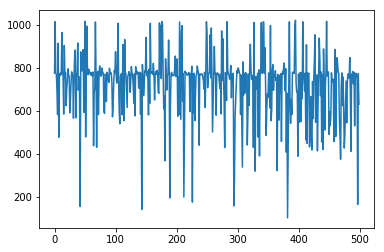

In [16]:
# env2, t_policy, t_val, rewards = ppo('InvertedPendulum-v2', 100, policy, value_fn)
t_policy, t_val, t_gate, rewards, arg_dict = ppo_switch(
    "su_cartpole_push-v0", 500, policy, value_fn, gate_fn, epoch_batch_size=50
)

plt.plot(rewards)
print(rewards)